In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

from models.activ_func import *
from models.Nets import *
from models.test import test_img
from models.Update import *

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser

import torchvision

%load_ext autoreload
%autoreload 2

class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 1  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 128  #"local batch size: B"
    bs        = 128 #"test batch size"
    lr        = 0.1 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    split     = 'user' # "train-test split type, user or sample"

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root="./data/cifar", train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=args.bs, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root="./data/cifar", train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=args.bs, shuffle=False, num_workers=2)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [2]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

#         images.resize_(images.shape[0], 3*32*32)

        images = images.cuda()
        labels = labels.cuda()

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [10]:
from torch.nn import Module
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.core.quant import QuantType


from models.vgg import *

import math

                    
net = VGG('VGG11')
net.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Conv2d(256, 51

In [11]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=3e-4)

# optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0002, nesterov=True)

train_accuracy_Relu = []
train_loss_Relu = []
test_accuracy_Relu  = []
test_loss_Relu  = []


for epoch in range(200):
    
    if epoch <= 80:
        cur_lr = 0.001
    elif epoch <= 140:
        cur_lr = 0.0005
    else:    
        cur_lr = 0.0001

#     if epoch <= 60:
#         cur_lr = 0.05
#     elif epoch <= 120:
#         cur_lr = 0.01
#     elif epoch <= 160:    
#         cur_lr = 0.002
#     else:
#         cur_lr = 0.0004
#     optimizer = optim.SGD(net.parameters(), lr=cur_lr, momentum=0.9, weight_decay=0.0001)
    
    for g in optimizer.param_groups:
        g['lr'] = cur_lr
#     optimizer = optim.Adam(net.parameters(), lr=cur_lr, weight_decay=0.0001)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if args.gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

#         if epoch > 16:
#             for group in optimizer.param_groups:
#                 for p in group['params']:
#                     state = optimizer.state[p]
#                     if state['step'] >= 1024:
#                         state['step'] = 1000
        optimizer.step()


        # print statistics
        if i % 100 == 0:
            print(i,loss.data)
        running_loss += loss.data

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    test_loss, test_accuracy = validation(net, testloader, criterion)
    train_loss, train_accuracy = validation(net, trainloader, criterion)

    print("Iteration: {0} | Loss: {1} |".format(epoch+1, running_loss),
          "Train,Test accuracy: {0}.3f%, {1}.3f%".format(train_accuracy/len(trainloader), test_accuracy/len(testloader)) )
    
    train_accuracy_Relu.append(train_accuracy/len(trainloader))
    train_loss_Relu.append(train_loss)
    
    test_accuracy_Relu.append(test_accuracy/len(testloader))
    test_loss_Relu.append(test_loss)
    
    # Specify a path
    PATH = "./save_models/CIFAR10_VGG11_relu_E200_iter"+str(epoch)+".pt"
    torch.save(net.state_dict(), PATH)

0 tensor(2.2992, device='cuda:0')
100 tensor(1.5402, device='cuda:0')
200 tensor(1.4077, device='cuda:0')
300 tensor(1.4371, device='cuda:0')
Iteration: 1 | Loss: 1.5121257305145264 | Train,Test accuracy: 0.5327685475349426.3f%, 0.539655864238739.3f%
0 tensor(1.3398, device='cuda:0')
100 tensor(1.2915, device='cuda:0')
200 tensor(0.9962, device='cuda:0')
300 tensor(0.9332, device='cuda:0')
Iteration: 2 | Loss: 1.0909663438796997 | Train,Test accuracy: 0.6628236770629883.3f%, 0.6563488841056824.3f%
0 tensor(0.9677, device='cuda:0')
100 tensor(0.9513, device='cuda:0')
200 tensor(1.0188, device='cuda:0')
300 tensor(0.9661, device='cuda:0')
Iteration: 3 | Loss: 0.9079623818397522 | Train,Test accuracy: 0.7054027915000916.3f%, 0.7023338675498962.3f%
0 tensor(0.8110, device='cuda:0')
100 tensor(0.7948, device='cuda:0')
200 tensor(0.9047, device='cuda:0')
300 tensor(0.7853, device='cuda:0')
Iteration: 4 | Loss: 0.8063987493515015 | Train,Test accuracy: 0.7525854706764221.3f%, 0.72003561258316

Iteration: 33 | Loss: 0.27162623405456543 | Train,Test accuracy: 0.916236400604248.3f%, 0.8418710231781006.3f%
0 tensor(0.2962, device='cuda:0')
100 tensor(0.2962, device='cuda:0')
200 tensor(0.2168, device='cuda:0')
300 tensor(0.2641, device='cuda:0')
Iteration: 34 | Loss: 0.2727038562297821 | Train,Test accuracy: 0.9206002354621887.3f%, 0.839695394039154.3f%
0 tensor(0.2335, device='cuda:0')
100 tensor(0.3211, device='cuda:0')
200 tensor(0.2772, device='cuda:0')
300 tensor(0.3389, device='cuda:0')
Iteration: 35 | Loss: 0.26466643810272217 | Train,Test accuracy: 0.9149256348609924.3f%, 0.842563271522522.3f%
0 tensor(0.2769, device='cuda:0')
100 tensor(0.2872, device='cuda:0')
200 tensor(0.2951, device='cuda:0')
300 tensor(0.3326, device='cuda:0')
Iteration: 36 | Loss: 0.26590314507484436 | Train,Test accuracy: 0.9133711457252502.3f%, 0.8356408476829529.3f%
0 tensor(0.2891, device='cuda:0')
100 tensor(0.2151, device='cuda:0')
200 tensor(0.2956, device='cuda:0')
300 tensor(0.2479, devic

0 tensor(0.1856, device='cuda:0')
100 tensor(0.2000, device='cuda:0')
200 tensor(0.1807, device='cuda:0')
300 tensor(0.1488, device='cuda:0')
Iteration: 66 | Loss: 0.21145881712436676 | Train,Test accuracy: 0.9348225593566895.3f%, 0.8429588675498962.3f%
0 tensor(0.2515, device='cuda:0')
100 tensor(0.1717, device='cuda:0')
200 tensor(0.2172, device='cuda:0')
300 tensor(0.1770, device='cuda:0')
Iteration: 67 | Loss: 0.20946188271045685 | Train,Test accuracy: 0.9364410042762756.3f%, 0.8403876423835754.3f%
0 tensor(0.3195, device='cuda:0')
100 tensor(0.1499, device='cuda:0')
200 tensor(0.2319, device='cuda:0')
300 tensor(0.1727, device='cuda:0')
Iteration: 68 | Loss: 0.20495417714118958 | Train,Test accuracy: 0.9334718585014343.3f%, 0.8433544039726257.3f%
0 tensor(0.1263, device='cuda:0')
100 tensor(0.2206, device='cuda:0')
200 tensor(0.1883, device='cuda:0')
300 tensor(0.1144, device='cuda:0')
Iteration: 69 | Loss: 0.2063254863023758 | Train,Test accuracy: 0.9373041987419128.3f%, 0.853243

300 tensor(0.1013, device='cuda:0')
Iteration: 98 | Loss: 0.09381457418203354 | Train,Test accuracy: 0.9712516069412231.3f%, 0.864022970199585.3f%
0 tensor(0.1097, device='cuda:0')
100 tensor(0.1126, device='cuda:0')
200 tensor(0.0699, device='cuda:0')
300 tensor(0.1007, device='cuda:0')
Iteration: 99 | Loss: 0.09804291278123856 | Train,Test accuracy: 0.9697051048278809.3f%, 0.856210470199585.3f%
0 tensor(0.1252, device='cuda:0')
100 tensor(0.0633, device='cuda:0')
200 tensor(0.0866, device='cuda:0')
300 tensor(0.0878, device='cuda:0')
Iteration: 100 | Loss: 0.09924370795488358 | Train,Test accuracy: 0.9710517525672913.3f%, 0.8520569801330566.3f%
0 tensor(0.0456, device='cuda:0')
100 tensor(0.0987, device='cuda:0')
200 tensor(0.1691, device='cuda:0')
300 tensor(0.1121, device='cuda:0')
Iteration: 101 | Loss: 0.09217723459005356 | Train,Test accuracy: 0.9729299545288086.3f%, 0.8493868708610535.3f%
0 tensor(0.0386, device='cuda:0')
100 tensor(0.1194, device='cuda:0')
200 tensor(0.0610, d

0 tensor(0.0983, device='cuda:0')
100 tensor(0.1070, device='cuda:0')
200 tensor(0.1154, device='cuda:0')
300 tensor(0.0920, device='cuda:0')
Iteration: 131 | Loss: 0.09336642920970917 | Train,Test accuracy: 0.9708600044250488.3f%, 0.8522547483444214.3f%
0 tensor(0.0452, device='cuda:0')
100 tensor(0.0535, device='cuda:0')
200 tensor(0.0592, device='cuda:0')
300 tensor(0.1499, device='cuda:0')
Iteration: 132 | Loss: 0.08828316628932953 | Train,Test accuracy: 0.9730898141860962.3f%, 0.8590783476829529.3f%
0 tensor(0.1352, device='cuda:0')
100 tensor(0.0632, device='cuda:0')
200 tensor(0.1504, device='cuda:0')
300 tensor(0.0329, device='cuda:0')
Iteration: 133 | Loss: 0.09110604226589203 | Train,Test accuracy: 0.9732217192649841.3f%, 0.8579905033111572.3f%
0 tensor(0.1055, device='cuda:0')
100 tensor(0.1915, device='cuda:0')
200 tensor(0.1201, device='cuda:0')
300 tensor(0.0600, device='cuda:0')
Iteration: 134 | Loss: 0.08905460685491562 | Train,Test accuracy: 0.9760109782218933.3f%, 0.8

200 tensor(0.0109, device='cuda:0')
300 tensor(0.0061, device='cuda:0')
Iteration: 163 | Loss: 0.014909118413925171 | Train,Test accuracy: 0.9956042170524597.3f%, 0.8740110993385315.3f%
0 tensor(0.0160, device='cuda:0')
100 tensor(0.0383, device='cuda:0')
200 tensor(0.0041, device='cuda:0')
300 tensor(0.0055, device='cuda:0')
Iteration: 164 | Loss: 0.014852884225547314 | Train,Test accuracy: 0.9958919286727905.3f%, 0.8731210231781006.3f%
0 tensor(0.0054, device='cuda:0')
100 tensor(0.0077, device='cuda:0')
200 tensor(0.0206, device='cuda:0')
300 tensor(0.0517, device='cuda:0')
Iteration: 165 | Loss: 0.01570245437324047 | Train,Test accuracy: 0.9950447678565979.3f%, 0.8737143874168396.3f%
0 tensor(0.0069, device='cuda:0')
100 tensor(0.0057, device='cuda:0')
200 tensor(0.0199, device='cuda:0')
300 tensor(0.0037, device='cuda:0')
Iteration: 166 | Loss: 0.015115943737328053 | Train,Test accuracy: 0.9944652915000916.3f%, 0.8691653609275818.3f%
0 tensor(0.0070, device='cuda:0')
100 tensor(0.

300 tensor(0.0060, device='cuda:0')
Iteration: 195 | Loss: 0.012667253613471985 | Train,Test accuracy: 0.9968230724334717.3f%, 0.8671875.3f%
0 tensor(0.0027, device='cuda:0')
100 tensor(0.0175, device='cuda:0')
200 tensor(0.0015, device='cuda:0')
300 tensor(0.0026, device='cuda:0')
Iteration: 196 | Loss: 0.013943570666015148 | Train,Test accuracy: 0.9961037635803223.3f%, 0.8682753443717957.3f%
0 tensor(0.0094, device='cuda:0')
100 tensor(0.0016, device='cuda:0')
200 tensor(0.0077, device='cuda:0')
300 tensor(0.0162, device='cuda:0')
Iteration: 197 | Loss: 0.013696941547095776 | Train,Test accuracy: 0.9950248003005981.3f%, 0.870352029800415.3f%
0 tensor(0.0125, device='cuda:0')
100 tensor(0.0256, device='cuda:0')
200 tensor(0.0121, device='cuda:0')
300 tensor(0.0070, device='cuda:0')
Iteration: 198 | Loss: 0.013309923000633717 | Train,Test accuracy: 0.9964433908462524.3f%, 0.8722310066223145.3f%
0 tensor(0.0096, device='cuda:0')
100 tensor(0.0048, device='cuda:0')
200 tensor(0.0292, dev

In [6]:
from torch.nn import Module
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.core.quant import QuantType

bit_width_sel = 8

class qVGG_xsquare2(nn.Module):
    def __init__(self, vgg_name):
        super(qVGG_xsquare2, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                #layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
            else:
                layers += [qnn.QuantConv2d(in_channels, out_channels=x, kernel_size=3, padding=1, weight_quant_type=QuantType.INT, 
                                     weight_bit_width=bit_width_sel),
                           nn.BatchNorm2d(x),
                           qnn.QuantXsquare2(quant_type=QuantType.INT, bit_width=8, max_val=6)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    
                    
net = qVGG_xsquare2('VGG11')
net.cuda()

qVGG_xsquare2(
  (features): Sequential(
    (0): QuantConv2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_reg): WeightReg()
      (weight_quant): WeightQuantProxy(
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RestrictValue(
              (forward_impl): RecursiveScriptModule(
                original_name=Sequential
                (0): RoundSte()
                (1): Identity()
              )
            )
            (tensor_clamp_impl): TensorClampSte()
          )
          (scaling_impl): ParameterStatsScaling(
            (parameter_list_stats): ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper()
              (stats): Stats(
                (stats_impl): AbsMax()
              )
            )
            (stats_scaling_impl): StatsScaling(
              (affine_rescaling): Identity()
              (restrict_scaling): RestrictValue(
                (forw

In [8]:
# net = DNNCifar(args=args).to(args.device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=3e-4)

# optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001)

train_accuracy_qXsquare2 = []
train_loss_qXsquare2 = []
test_accuracy_qXsquare2  = []
test_loss_qXsquare2  = []


for epoch in range(200):
    
    if epoch <= 80:
        cur_lr = 0.001
    elif epoch <= 140:
        cur_lr = 0.0005
    else:    
        cur_lr = 0.0001
#     else:
#         cur_lr = 0.0004
    
    for g in optimizer.param_groups:
        g['lr'] = cur_lr
        
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if args.gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        if epoch > 16:
            for group in optimizer.param_groups:
                for p in group['params']:
                    state = optimizer.state[p]
                    if state['step'] >= 1024:
                        state['step'] = 1000
        optimizer.step()


        # print statistics
        if i % 100 == 0:
            print(i,loss.data)
        running_loss += loss.data

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    test_loss, test_accuracy = validation(net, testloader, criterion)
    train_loss, train_accuracy = validation(net, trainloader, criterion)

    print("Iteration: {0} | Loss: {1} |".format(epoch+1, running_loss),
          "Train,Test accuracy: {0}.3f%, {1}.3f%".format(train_accuracy/len(trainloader), test_accuracy/len(testloader)) )
    
    train_accuracy_qXsquare2.append(train_accuracy/len(trainloader))
    train_loss_qXsquare2.append(train_loss)
    
    test_accuracy_qXsquare2.append(test_accuracy/len(testloader))
    test_loss_qXsquare2.append(test_loss)
    
    # Specify a path
    PATH = "./save_models/CIFAR10_VGG11_xsq2_E200_iter"+str(epoch)+"_v1.pt"
    torch.save(net.state_dict(), PATH)

    # save model
#     if epoch % 50 == 0:
#         print('==> Saving model ...')
#         state = {
#             'net': net.module if opt.is_gpu else net,
#             'epoch': epoch,
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, '../checkpoint/ckpt.t7')

print('==> Finished Training ...')

0 tensor(2.4069, device='cuda:0')
100 tensor(2.1011, device='cuda:0')
200 tensor(1.9429, device='cuda:0')
300 tensor(1.6888, device='cuda:0')
Iteration: 1 | Loss: 1.8848611116409302 | Train,Test accuracy: 0.45572251081466675.3f%, 0.42850080132484436.3f%
0 tensor(1.3843, device='cuda:0')
100 tensor(1.4497, device='cuda:0')
200 tensor(1.4741, device='cuda:0')
300 tensor(1.1314, device='cuda:0')
Iteration: 2 | Loss: 1.286672592163086 | Train,Test accuracy: 0.6202325820922852.3f%, 0.5982990264892578.3f%
0 tensor(1.0478, device='cuda:0')
100 tensor(1.1821, device='cuda:0')
200 tensor(0.9913, device='cuda:0')
300 tensor(0.9234, device='cuda:0')
Iteration: 3 | Loss: 0.9837508797645569 | Train,Test accuracy: 0.6982736587524414.3f%, 0.6641613841056824.3f%
0 tensor(0.7789, device='cuda:0')
100 tensor(0.8581, device='cuda:0')
200 tensor(0.9102, device='cuda:0')
300 tensor(0.7074, device='cuda:0')
Iteration: 4 | Loss: 0.8097448348999023 | Train,Test accuracy: 0.7561261653900146.3f%, 0.723496854305

Iteration: 33 | Loss: 0.16055287420749664 | Train,Test accuracy: 0.9517542719841003.3f%, 0.8473101258277893.3f%
0 tensor(0.2019, device='cuda:0')
100 tensor(0.1058, device='cuda:0')
200 tensor(0.1747, device='cuda:0')
300 tensor(0.1181, device='cuda:0')
Iteration: 34 | Loss: 0.15610459446907043 | Train,Test accuracy: 0.9515065550804138.3f%, 0.8468156456947327.3f%
0 tensor(0.1056, device='cuda:0')
100 tensor(0.1104, device='cuda:0')
200 tensor(0.2101, device='cuda:0')
300 tensor(0.1156, device='cuda:0')
Iteration: 35 | Loss: 0.15624983608722687 | Train,Test accuracy: 0.953940212726593.3f%, 0.8418710231781006.3f%
0 tensor(0.0903, device='cuda:0')
100 tensor(0.0776, device='cuda:0')
200 tensor(0.1325, device='cuda:0')
300 tensor(0.1895, device='cuda:0')
Iteration: 36 | Loss: 0.15538841485977173 | Train,Test accuracy: 0.9540161490440369.3f%, 0.8349485993385315.3f%
0 tensor(0.2148, device='cuda:0')
100 tensor(0.1614, device='cuda:0')
200 tensor(0.2330, device='cuda:0')
300 tensor(0.1213, de

0 tensor(0.1622, device='cuda:0')
100 tensor(0.1899, device='cuda:0')
200 tensor(0.1317, device='cuda:0')
300 tensor(0.1208, device='cuda:0')
Iteration: 66 | Loss: 0.12479391694068909 | Train,Test accuracy: 0.96535325050354.3f%, 0.8543314933776855.3f%
0 tensor(0.0862, device='cuda:0')
100 tensor(0.0834, device='cuda:0')
200 tensor(0.2288, device='cuda:0')
300 tensor(0.1107, device='cuda:0')
Iteration: 67 | Loss: 0.12204067409038544 | Train,Test accuracy: 0.9609215259552002.3f%, 0.8492879867553711.3f%
0 tensor(0.0723, device='cuda:0')
100 tensor(0.2395, device='cuda:0')
200 tensor(0.1095, device='cuda:0')
300 tensor(0.1455, device='cuda:0')
Iteration: 68 | Loss: 0.12264156341552734 | Train,Test accuracy: 0.9657408595085144.3f%, 0.8446400165557861.3f%
0 tensor(0.0849, device='cuda:0')
100 tensor(0.1060, device='cuda:0')
200 tensor(0.1574, device='cuda:0')
300 tensor(0.1541, device='cuda:0')
Iteration: 69 | Loss: 0.11853756010532379 | Train,Test accuracy: 0.9636149406433105.3f%, 0.8410798

300 tensor(0.0225, device='cuda:0')
Iteration: 98 | Loss: 0.05276075378060341 | Train,Test accuracy: 0.9845628142356873.3f%, 0.8580893874168396.3f%
0 tensor(0.0573, device='cuda:0')
100 tensor(0.0347, device='cuda:0')
200 tensor(0.0754, device='cuda:0')
300 tensor(0.0304, device='cuda:0')
Iteration: 99 | Loss: 0.05254628509283066 | Train,Test accuracy: 0.9838155508041382.3f%, 0.8546281456947327.3f%
0 tensor(0.0249, device='cuda:0')
100 tensor(0.0274, device='cuda:0')
200 tensor(0.0277, device='cuda:0')
300 tensor(0.0280, device='cuda:0')
Iteration: 100 | Loss: 0.052360910922288895 | Train,Test accuracy: 0.9824248552322388.3f%, 0.8542326092720032.3f%
0 tensor(0.0355, device='cuda:0')
100 tensor(0.0206, device='cuda:0')
200 tensor(0.0129, device='cuda:0')
300 tensor(0.0590, device='cuda:0')
Iteration: 101 | Loss: 0.051820430904626846 | Train,Test accuracy: 0.9851303100585938.3f%, 0.8532436490058899.3f%
0 tensor(0.0166, device='cuda:0')
100 tensor(0.0190, device='cuda:0')
200 tensor(0.018

0 tensor(0.0637, device='cuda:0')
100 tensor(0.0369, device='cuda:0')
200 tensor(0.0419, device='cuda:0')
300 tensor(0.0944, device='cuda:0')
Iteration: 131 | Loss: 0.05280294641852379 | Train,Test accuracy: 0.9838834404945374.3f%, 0.8534414768218994.3f%
0 tensor(0.0162, device='cuda:0')
100 tensor(0.0623, device='cuda:0')
200 tensor(0.0662, device='cuda:0')
300 tensor(0.0136, device='cuda:0')
Iteration: 132 | Loss: 0.05186932161450386 | Train,Test accuracy: 0.9833439588546753.3f%, 0.8544303774833679.3f%
0 tensor(0.0685, device='cuda:0')
100 tensor(0.0403, device='cuda:0')
200 tensor(0.0969, device='cuda:0')
300 tensor(0.0717, device='cuda:0')
Iteration: 133 | Loss: 0.053128719329833984 | Train,Test accuracy: 0.9852342009544373.3f%, 0.853342592716217.3f%
0 tensor(0.0313, device='cuda:0')
100 tensor(0.0407, device='cuda:0')
200 tensor(0.0236, device='cuda:0')
300 tensor(0.0771, device='cuda:0')
Iteration: 134 | Loss: 0.048060342669487 | Train,Test accuracy: 0.984043300151825.3f%, 0.8546

100 tensor(0.0172, device='cuda:0')
200 tensor(0.0011, device='cuda:0')
300 tensor(0.0057, device='cuda:0')
Iteration: 163 | Loss: 0.007399177644401789 | Train,Test accuracy: 0.9979619383811951.3f%, 0.8727254867553711.3f%
0 tensor(0.0011, device='cuda:0')
100 tensor(0.0102, device='cuda:0')
200 tensor(0.0010, device='cuda:0')
300 tensor(0.0025, device='cuda:0')
Iteration: 164 | Loss: 0.006926909554749727 | Train,Test accuracy: 0.9976822137832642.3f%, 0.8729232549667358.3f%
0 tensor(0.0013, device='cuda:0')
100 tensor(0.0198, device='cuda:0')
200 tensor(0.0004, device='cuda:0')
300 tensor(0.0285, device='cuda:0')
Iteration: 165 | Loss: 0.007756717968732119 | Train,Test accuracy: 0.9981817603111267.3f%, 0.8710442781448364.3f%
0 tensor(0.0014, device='cuda:0')
100 tensor(0.0141, device='cuda:0')
200 tensor(0.0070, device='cuda:0')
300 tensor(0.0051, device='cuda:0')
Iteration: 166 | Loss: 0.007576040457934141 | Train,Test accuracy: 0.997482419013977.3f%, 0.8688686490058899.3f%
0 tensor(0.

200 tensor(0.0005, device='cuda:0')
300 tensor(0.0050, device='cuda:0')
Iteration: 195 | Loss: 0.006790527608245611 | Train,Test accuracy: 0.9985813498497009.3f%, 0.8700553774833679.3f%
0 tensor(0.0242, device='cuda:0')
100 tensor(0.0012, device='cuda:0')
200 tensor(0.0189, device='cuda:0')
300 tensor(0.0102, device='cuda:0')
Iteration: 196 | Loss: 0.006438868585973978 | Train,Test accuracy: 0.9985613822937012.3f%, 0.8728243708610535.3f%
0 tensor(0.0034, device='cuda:0')
100 tensor(0.0029, device='cuda:0')
200 tensor(0.0153, device='cuda:0')
300 tensor(0.0175, device='cuda:0')
Iteration: 197 | Loss: 0.007481008302420378 | Train,Test accuracy: 0.9976622462272644.3f%, 0.8717365264892578.3f%
0 tensor(0.0025, device='cuda:0')
100 tensor(0.0072, device='cuda:0')
200 tensor(0.0120, device='cuda:0')
300 tensor(0.0039, device='cuda:0')
Iteration: 198 | Loss: 0.007488665170967579 | Train,Test accuracy: 0.9978820085525513.3f%, 0.8746044039726257.3f%
0 tensor(0.0013, device='cuda:0')
100 tensor(0

In [12]:
from torch.nn import Module
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.core.quant import QuantType

bit_width_sel = 8

class qVGG_xsquare(nn.Module):
    def __init__(self, vgg_name):
        super(qVGG_xsquare, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                #layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
            else:
                layers += [qnn.QuantConv2d(in_channels, out_channels=x, kernel_size=3, padding=1, weight_quant_type=QuantType.INT, 
                                     weight_bit_width=bit_width_sel),
                           nn.BatchNorm2d(x),
                           qnn.QuantXsquare(quant_type=QuantType.INT, bit_width=8, max_val=6)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    
                    
net = qVGG_xsquare('VGG11')
net.cuda()

qVGG_xsquare(
  (features): Sequential(
    (0): QuantConv2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_reg): WeightReg()
      (weight_quant): WeightQuantProxy(
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RestrictValue(
              (forward_impl): RecursiveScriptModule(
                original_name=Sequential
                (0): RoundSte()
                (1): Identity()
              )
            )
            (tensor_clamp_impl): TensorClampSte()
          )
          (scaling_impl): ParameterStatsScaling(
            (parameter_list_stats): ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper()
              (stats): Stats(
                (stats_impl): AbsMax()
              )
            )
            (stats_scaling_impl): StatsScaling(
              (affine_rescaling): Identity()
              (restrict_scaling): RestrictValue(
                (forwa

In [13]:
# net = DNNCifar(args=args).to(args.device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=3e-4)

# optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001)

train_accuracy_qXsquare = []
train_loss_qXsquare = []
test_accuracy_qXsquare  = []
test_loss_qXsquare  = []


for epoch in range(200):
    
    if epoch <= 80:
        cur_lr = 0.001
    elif epoch <= 140:
        cur_lr = 0.0005
    else:    
        cur_lr = 0.0001
#     else:
#         cur_lr = 0.0004
    
    for g in optimizer.param_groups:
        g['lr'] = cur_lr
        
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if args.gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        if epoch > 16:
            for group in optimizer.param_groups:
                for p in group['params']:
                    state = optimizer.state[p]
                    if state['step'] >= 1024:
                        state['step'] = 1000
        optimizer.step()


        # print statistics
        if i % 100 == 0:
            print(i,loss.data)
        running_loss += loss.data

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    test_loss, test_accuracy = validation(net, testloader, criterion)
    train_loss, train_accuracy = validation(net, trainloader, criterion)

    print("Iteration: {0} | Loss: {1} |".format(epoch+1, running_loss),
          "Train,Test accuracy: {0}.3f%, {1}.3f%".format(train_accuracy/len(trainloader), test_accuracy/len(testloader)) )
    
    train_accuracy_qXsquare.append(train_accuracy/len(trainloader))
    train_loss_qXsquare.append(train_loss)
    
    test_accuracy_qXsquare.append(test_accuracy/len(testloader))
    test_loss_qXsquare.append(test_loss)
    
    # Specify a path
    PATH = "./save_models/CIFAR10_VGG11_xsq_E200_iter"+str(epoch)+"_v1.pt"
    torch.save(net.state_dict(), PATH)

    # save model
#     if epoch % 50 == 0:
#         print('==> Saving model ...')
#         state = {
#             'net': net.module if opt.is_gpu else net,
#             'epoch': epoch,
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, '../checkpoint/ckpt.t7')

print('==> Finished Training ...')

0 tensor(2.4825, device='cuda:0')
100 tensor(2.3049, device='cuda:0')
200 tensor(2.1837, device='cuda:0')
300 tensor(2.0935, device='cuda:0')
Iteration: 1 | Loss: 2.2176079750061035 | Train,Test accuracy: 0.2139306217432022.3f%, 0.20065268874168396.3f%
0 tensor(2.1044, device='cuda:0')
100 tensor(2.0587, device='cuda:0')
200 tensor(1.9165, device='cuda:0')
300 tensor(1.7028, device='cuda:0')
Iteration: 2 | Loss: 1.8930039405822754 | Train,Test accuracy: 0.35620203614234924.3f%, 0.36085838079452515.3f%
0 tensor(1.8674, device='cuda:0')
100 tensor(1.5362, device='cuda:0')
200 tensor(1.5074, device='cuda:0')
300 tensor(1.4186, device='cuda:0')
Iteration: 3 | Loss: 1.5230740308761597 | Train,Test accuracy: 0.5346307158470154.3f%, 0.5048457384109497.3f%
0 tensor(1.3298, device='cuda:0')
100 tensor(1.3659, device='cuda:0')
200 tensor(1.0783, device='cuda:0')
300 tensor(1.0243, device='cuda:0')
Iteration: 4 | Loss: 1.1532636880874634 | Train,Test accuracy: 0.6573768854141235.3f%, 0.6210442781

300 tensor(0.1795, device='cuda:0')
Iteration: 33 | Loss: 0.15842460095882416 | Train,Test accuracy: 0.9508112072944641.3f%, 0.8390031456947327.3f%
0 tensor(0.1140, device='cuda:0')
100 tensor(0.2567, device='cuda:0')
200 tensor(0.1303, device='cuda:0')
300 tensor(0.1283, device='cuda:0')
Iteration: 34 | Loss: 0.16433629393577576 | Train,Test accuracy: 0.95414799451828.3f%, 0.8363330960273743.3f%
0 tensor(0.1333, device='cuda:0')
100 tensor(0.1069, device='cuda:0')
200 tensor(0.0813, device='cuda:0')
300 tensor(0.1712, device='cuda:0')
Iteration: 35 | Loss: 0.15894900262355804 | Train,Test accuracy: 0.9511988759040833.3f%, 0.8433544039726257.3f%
0 tensor(0.1134, device='cuda:0')
100 tensor(0.2731, device='cuda:0')
200 tensor(0.1097, device='cuda:0')
300 tensor(0.0937, device='cuda:0')
Iteration: 36 | Loss: 0.15414714813232422 | Train,Test accuracy: 0.9555466771125793.3f%, 0.8448378443717957.3f%
0 tensor(0.0802, device='cuda:0')
100 tensor(0.1583, device='cuda:0')
200 tensor(0.1862, dev

0 tensor(0.0998, device='cuda:0')
100 tensor(0.0931, device='cuda:0')
200 tensor(0.2760, device='cuda:0')
300 tensor(0.0701, device='cuda:0')
Iteration: 66 | Loss: 0.12435042858123779 | Train,Test accuracy: 0.9659087657928467.3f%, 0.8404865264892578.3f%
0 tensor(0.1630, device='cuda:0')
100 tensor(0.1546, device='cuda:0')
200 tensor(0.0669, device='cuda:0')
300 tensor(0.1274, device='cuda:0')
Iteration: 67 | Loss: 0.12174427509307861 | Train,Test accuracy: 0.9644980430603027.3f%, 0.8474090099334717.3f%
0 tensor(0.0932, device='cuda:0')
100 tensor(0.1055, device='cuda:0')
200 tensor(0.1278, device='cuda:0')
300 tensor(0.1592, device='cuda:0')
Iteration: 68 | Loss: 0.12501846253871918 | Train,Test accuracy: 0.968957781791687.3f%, 0.8441455960273743.3f%
0 tensor(0.0750, device='cuda:0')
100 tensor(0.0660, device='cuda:0')
200 tensor(0.1560, device='cuda:0')
300 tensor(0.0459, device='cuda:0')
Iteration: 69 | Loss: 0.12076500058174133 | Train,Test accuracy: 0.959574818611145.3f%, 0.8414754

300 tensor(0.0312, device='cuda:0')
Iteration: 98 | Loss: 0.05257264897227287 | Train,Test accuracy: 0.9845427870750427.3f%, 0.855617105960846.3f%
0 tensor(0.0593, device='cuda:0')
100 tensor(0.1132, device='cuda:0')
200 tensor(0.0415, device='cuda:0')
300 tensor(0.0172, device='cuda:0')
Iteration: 99 | Loss: 0.05008157342672348 | Train,Test accuracy: 0.9840952754020691.3f%, 0.8534414768218994.3f%
0 tensor(0.0330, device='cuda:0')
100 tensor(0.0566, device='cuda:0')
200 tensor(0.0697, device='cuda:0')
300 tensor(0.0335, device='cuda:0')
Iteration: 100 | Loss: 0.053936414420604706 | Train,Test accuracy: 0.9858136177062988.3f%, 0.8534414768218994.3f%
0 tensor(0.0210, device='cuda:0')
100 tensor(0.0586, device='cuda:0')
200 tensor(0.0553, device='cuda:0')
300 tensor(0.1396, device='cuda:0')
Iteration: 101 | Loss: 0.04991893470287323 | Train,Test accuracy: 0.9864929914474487.3f%, 0.8519580960273743.3f%
0 tensor(0.0243, device='cuda:0')
100 tensor(0.0949, device='cuda:0')
200 tensor(0.0131,

Iteration: 130 | Loss: 0.05286867544054985 | Train,Test accuracy: 0.9820332527160645.3f%, 0.8536392450332642.3f%
0 tensor(0.0389, device='cuda:0')
100 tensor(0.0463, device='cuda:0')
200 tensor(0.0182, device='cuda:0')
300 tensor(0.1154, device='cuda:0')
Iteration: 131 | Loss: 0.05282042548060417 | Train,Test accuracy: 0.9833838939666748.3f%, 0.8594738841056824.3f%
0 tensor(0.0428, device='cuda:0')
100 tensor(0.0438, device='cuda:0')
200 tensor(0.0188, device='cuda:0')
300 tensor(0.0647, device='cuda:0')
Iteration: 132 | Loss: 0.05032088980078697 | Train,Test accuracy: 0.9847426414489746.3f%, 0.8573971390724182.3f%
0 tensor(0.0496, device='cuda:0')
100 tensor(0.0118, device='cuda:0')
200 tensor(0.0906, device='cuda:0')
300 tensor(0.0878, device='cuda:0')
Iteration: 133 | Loss: 0.05243371054530144 | Train,Test accuracy: 0.9821251034736633.3f%, 0.8558148741722107.3f%
0 tensor(0.0720, device='cuda:0')
100 tensor(0.0241, device='cuda:0')
200 tensor(0.0378, device='cuda:0')
300 tensor(0.029

0 tensor(0.0013, device='cuda:0')
100 tensor(0.0147, device='cuda:0')
200 tensor(0.0061, device='cuda:0')
300 tensor(0.0017, device='cuda:0')
Iteration: 163 | Loss: 0.007735142949968576 | Train,Test accuracy: 0.9977021813392639.3f%, 0.8688686490058899.3f%
0 tensor(0.0028, device='cuda:0')
100 tensor(0.0006, device='cuda:0')
200 tensor(0.0034, device='cuda:0')
300 tensor(0.0005, device='cuda:0')
Iteration: 164 | Loss: 0.006307836156338453 | Train,Test accuracy: 0.9980019330978394.3f%, 0.8663963675498962.3f%
0 tensor(0.0008, device='cuda:0')
100 tensor(0.0129, device='cuda:0')
200 tensor(0.0016, device='cuda:0')
300 tensor(0.0040, device='cuda:0')
Iteration: 165 | Loss: 0.007146948017179966 | Train,Test accuracy: 0.9984415173530579.3f%, 0.871835470199585.3f%
0 tensor(0.0015, device='cuda:0')
100 tensor(0.0184, device='cuda:0')
200 tensor(0.0149, device='cuda:0')
300 tensor(0.0014, device='cuda:0')
Iteration: 166 | Loss: 0.006230125669389963 | Train,Test accuracy: 0.9982816576957703.3f%, 

100 tensor(0.0470, device='cuda:0')
200 tensor(0.0010, device='cuda:0')
300 tensor(0.0009, device='cuda:0')
Iteration: 195 | Loss: 0.007358235772699118 | Train,Test accuracy: 0.997822105884552.3f%, 0.8658030033111572.3f%
0 tensor(0.0029, device='cuda:0')
100 tensor(0.0009, device='cuda:0')
200 tensor(0.0453, device='cuda:0')
300 tensor(0.0022, device='cuda:0')
Iteration: 196 | Loss: 0.007463912013918161 | Train,Test accuracy: 0.9977821111679077.3f%, 0.8674841523170471.3f%
0 tensor(0.0051, device='cuda:0')
100 tensor(0.0099, device='cuda:0')
200 tensor(0.0074, device='cuda:0')
300 tensor(0.0059, device='cuda:0')
Iteration: 197 | Loss: 0.007066397462040186 | Train,Test accuracy: 0.9978500604629517.3f%, 0.8672863841056824.3f%
0 tensor(0.0079, device='cuda:0')
100 tensor(0.0039, device='cuda:0')
200 tensor(0.0027, device='cuda:0')
300 tensor(0.0091, device='cuda:0')
Iteration: 198 | Loss: 0.007193475030362606 | Train,Test accuracy: 0.9980019330978394.3f%, 0.8658030033111572.3f%
0 tensor(0.

In [16]:
import pickle

filehandler = open("./plot/CIFAR10_VGG11_BN_ReLU_train","wb")
pickle.dump(train_accuracy_Relu,filehandler)
filehandler = open("./plot/CIFAR10_VGG11_BN_ReLU_test","wb")
pickle.dump(test_accuracy_Relu,filehandler)

filehandler = open("./plot/CIFAR10_VGG11_BN_Xsq2_train","wb")
pickle.dump(train_accuracy_qXsquare2,filehandler)
filehandler = open("./plot/CIFAR10_VGG11_BN_Xsq2_test","wb")
pickle.dump(test_accuracy_qXsquare2,filehandler)

filehandler = open("./plot/CIFAR10_VGG11_BN_Xsq_train","wb")
pickle.dump(train_accuracy_qXsquare,filehandler)
filehandler = open("./plot/CIFAR10_VGG11_BN_Xsq_test","wb")
pickle.dump(test_accuracy_qXsquare,filehandler)

tensor(0.8493) tensor(0.8712)
tensor(0.8461) tensor(0.8652)
tensor(0.8437) tensor(0.8632)


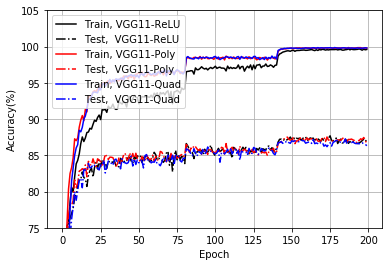

In [21]:
import pickle
import matplotlib.pyplot as plt
import matplotlib

# train_accuracy_Relu = pickle.load(open('./plot/CIFAR10_CNN_ReLU_v2_train','rb'))
# test_accuracy_Relu = pickle.load(open('./plot/CIFAR10_CNN_ReLU_v2_test','rb'))

# train_accuracy_qXsquare2 = pickle.load(open('./plot/CIFAR10_NiN_Poly_v1_train','rb'))
# test_accuracy_qXsquare2 = pickle.load(open('./plot/CIFAR10_NiN_Poly_v1_test','rb'))

# train_accuracy_qXsquare = pickle.load(open('./plot/CIFAR10_CNN_Xsq_train','rb'))
# test_accuracy_qXsquare = pickle.load(open('./plot/CIFAR10_CNN_Xsq_test','rb'))


stt_pos = 0
end_pos = 200

print(test_accuracy_Relu[49], test_accuracy_Relu[end_pos-1])
print(test_accuracy_qXsquare2[49], test_accuracy_qXsquare2[end_pos-1])
print(test_accuracy_qXsquare[49],  test_accuracy_qXsquare[end_pos-1])

plt.plot(np.array(train_accuracy_Relu[stt_pos:end_pos])*100,'k')
plt.plot(np.array(test_accuracy_Relu[stt_pos:end_pos])*100,'k',linestyle='-.')

plt.plot(np.array(train_accuracy_qXsquare2[stt_pos:end_pos])*100,'r')
plt.plot(np.array(test_accuracy_qXsquare2[stt_pos:end_pos])*100,'r',linestyle='-.')

plt.plot(np.array(train_accuracy_qXsquare[stt_pos:end_pos])*100,'b')
plt.plot(np.array(test_accuracy_qXsquare[stt_pos:end_pos])*100,'b',linestyle='-.')


# plt.plot(acc_Brea,'b')
# plt.plot(acc_FedAvg_,'b',linestyle='-.')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')

plt.legend(['Train, VGG11-ReLU','Test,  VGG11-ReLU','Train, VGG11-Poly','Test,  VGG11-Poly' ,'Train, VGG11-Quad','Test,  VGG11-Quad' ])
plt.ylim([75,105])
plt.savefig('./plot/accuracy_CIFAR10_VGG11_BN_E'+str(end_pos)+'.png',dpi=300)
plt.show()

# 2. Without Batch Normalization

In [23]:
from torch.nn import Module
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.core.quant import QuantType

bit_width_sel = 8

class qVGG_xsquare2_woBN(nn.Module):
    def __init__(self, vgg_name):
        super(qVGG_xsquare2_woBN, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                #layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
            else:
                layers += [qnn.QuantConv2d(in_channels, out_channels=x, kernel_size=3, padding=1, weight_quant_type=QuantType.INT, 
                                     weight_bit_width=bit_width_sel),
#                            nn.BatchNorm2d(x),
                           qnn.QuantXsquare2(quant_type=QuantType.INT, bit_width=8, max_val=6)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    
                    


qVGG_xsquare2_woBN(
  (features): Sequential(
    (0): QuantConv2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_reg): WeightReg()
      (weight_quant): WeightQuantProxy(
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RestrictValue(
              (forward_impl): RecursiveScriptModule(
                original_name=Sequential
                (0): RoundSte()
                (1): Identity()
              )
            )
            (tensor_clamp_impl): TensorClampSte()
          )
          (scaling_impl): ParameterStatsScaling(
            (parameter_list_stats): ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper()
              (stats): Stats(
                (stats_impl): AbsMax()
              )
            )
            (stats_scaling_impl): StatsScaling(
              (affine_rescaling): Identity()
              (restrict_scaling): RestrictValue(
                

In [27]:
# net = DNNCifar(args=args).to(args.device)

lr_array = [0.1, 0.01, 0.001, 0.0001]
Max_iter = 10

train_accuracy_qXsquare2_woBN = np.zeros((len(lr_array), Max_iter))
train_loss_qXsquare2_woBN     = np.zeros((len(lr_array), Max_iter))
test_accuracy_qXsquare2_woBN  = np.zeros((len(lr_array), Max_iter))
test_loss_qXsquare2_woBN      = np.zeros((len(lr_array), Max_iter))


for lr_idx in range(len(lr_array)):
    
    cur_lr = lr_array[lr_idx]
    
    print()
    print('Learning rate=', cur_lr)
    print()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=cur_lr, weight_decay=3e-4)

    # optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001)
    
    

    net = qVGG_xsquare2_woBN('VGG11')
    net.cuda()

    for epoch in range(200):

#         if epoch <= 80:
#             cur_lr = 0.001
#         elif epoch <= 140:
#             cur_lr = 0.0005
#         else:    
#             cur_lr = 0.0001
    #     else:
    #         cur_lr = 0.0004

#         for g in optimizer.param_groups:
#             g['lr'] = cur_lr

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            if args.gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            if epoch > 16:
                for group in optimizer.param_groups:
                    for p in group['params']:
                        state = optimizer.state[p]
                        if state['step'] >= 1024:
                            state['step'] = 1000
            optimizer.step()


            # print statistics
            if i % 100 == 0:
                print(i,loss.data)
            running_loss += loss.data

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

        # Calculate training/test set accuracy of the existing model
        test_loss, test_accuracy = validation(net, testloader, criterion)
        train_loss, train_accuracy = validation(net, trainloader, criterion)

        print("Iteration: {0} | Loss: {1} |".format(epoch+1, running_loss),
              "Train,Test accuracy: {0}.3f%, {1}.3f%".format(train_accuracy/len(trainloader), test_accuracy/len(testloader)) )

        train_accuracy_qXsquare2_woBN[lr_idx][epoch] = (train_accuracy/len(trainloader))
        train_loss_qXsquare2_woBN[lr_idx][epoch] = (train_loss)

        test_accuracy_qXsquare2_woBN[lr_idx][epoch] = (test_accuracy/len(testloader))
        test_loss_qXsquare2_woBN[lr_idx][epoch] = (test_loss)

        # Specify a path
#         PATH = "./save_models/CIFAR10_VGG11_woBN_xsq2_E200_iter"+str(epoch)+"_v1.pt"
#         torch.save(net.state_dict(), PATH)

    # save model
#     if epoch % 50 == 0:
#         print('==> Saving model ...')
#         state = {
#             'net': net.module if opt.is_gpu else net,
#             'epoch': epoch,
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, '../checkpoint/ckpt.t7')

print('==> Finished Training ...')


Learning rate= 0.1

0 tensor(2.3044, device='cuda:0')
100 tensor(2.3018, device='cuda:0')
200 tensor(2.3001, device='cuda:0')
300 tensor(2.3004, device='cuda:0')
Iteration: 1 | Loss: 2.30263614654541 | Train,Test accuracy: 0.08763586729764938.3f%, 0.09009098261594772.3f%
0 tensor(2.3036, device='cuda:0')
100 tensor(2.3013, device='cuda:0')
200 tensor(2.3013, device='cuda:0')
300 tensor(2.3026, device='cuda:0')
Iteration: 2 | Loss: 2.302642345428467 | Train,Test accuracy: 0.08751998841762543.3f%, 0.09009098261594772.3f%
0 tensor(2.3027, device='cuda:0')
100 tensor(2.3035, device='cuda:0')
200 tensor(2.3063, device='cuda:0')
300 tensor(2.3026, device='cuda:0')
Iteration: 3 | Loss: 2.3026182651519775 | Train,Test accuracy: 0.08734414726495743.3f%, 0.09009098261594772.3f%
0 tensor(2.3024, device='cuda:0')
100 tensor(2.3025, device='cuda:0')
200 tensor(2.3034, device='cuda:0')
300 tensor(2.3017, device='cuda:0')
Iteration: 4 | Loss: 2.302621603012085 | Train,Test accuracy: 0.08758791536092

IndexError: index 10 is out of bounds for axis 0 with size 10